__<span style="background-color:#ffffe0">第5章　時系列データを活用したビジネス事例</span>__

# 5.5　チャーンマネジメントのための離反時期予測（携帯電話サービス）

## ステップ1：準備

### 必要なモジュールの読み込み

In [1]:
#
# 必要なモジュールの読み込み
#

import pandas as pd 
import numpy as np

from lifelines import *
from lifelines.utils import median_survival_times
from lifelines.utils import concordance_index

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] #グラフサイズ
plt.rcParams['font.size'] = 14 #フォントサイズ

### データセットの読み込み

In [2]:
#
# 必要なデータセットの読み込み
#

dataset = 'chap5_7.csv'
df=pd.read_csv(dataset, index_col='id') 

print(df) #確認

            fiber_optic_internet  care_services  contract_2_years  \
id                                                                  
3575658945                     0              0                 0   
1612527640                     0              0                 0   
3030576346                     0              0                 0   
7597140346                     0              0                 0   
5846338138                     1              0                 1   
...                          ...            ...               ...   
7112472659                     0              0                 0   
5249470446                     1              0                 0   
3871698536                     0              0                 0   
6494681829                     0              0                 0   
4339680439                     0              0                 0   

            family_discount  online_application  tenure  churn  
id                                   

## ステップ2：離反時期（ユーザであるまでの期間）分析

### カプランマイヤー推定（全体の生存時間の分析）

In [3]:
#
# カプランマイヤー推定
#

# TとEの設定
T = df['tenure'] #生存期間（契約期間）
E = df['churn']  #イベント生起（離反）

# インスタンス生成
kmf = KaplanMeierFitter()

# 学習
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 9995 total observations, 6104 right-censored observations>

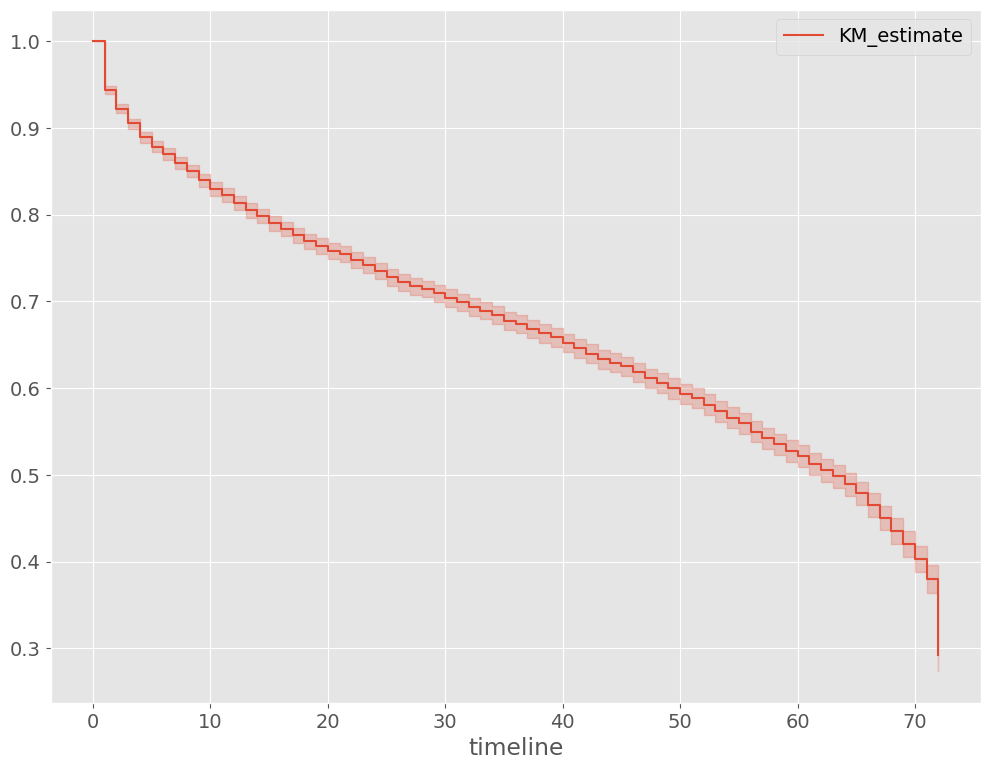

In [4]:
#
# 生存関数（時刻tまでに離反が発生していない確率）
#

kmf.plot_survival_function()
plt.show()

### Ridge Cox回帰

In [5]:
#
# Ridge Cox回帰
#

# インスタンス生成
cph = CoxPHFitter(
    penalizer=0.1, 
    l1_ratio=0)

# 学習
cph.fit(
    df, 
    duration_col='tenure', 
    event_col='churn') 

# 係数
print(cph.summary)

                          coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                             
fiber_optic_internet -0.494639   0.609791  0.031507       -0.556391   
care_services        -0.170257   0.843448  0.034519       -0.237913   
contract_2_years     -0.910868   0.402175  0.033984       -0.977475   
family_discount      -1.250884   0.286252  0.040187       -1.329649   
online_application    0.399007   1.490344  0.031381        0.337501   

                      coef upper 95%  exp(coef) lower 95%  \
covariate                                                   
fiber_optic_internet       -0.432886             0.573274   
care_services              -0.102601             0.788272   
contract_2_years           -0.844261             0.376260   
family_discount            -1.172120             0.264570   
online_application          0.460513             1.401441   

                      exp(coef) upper 95%  cmp to          z              

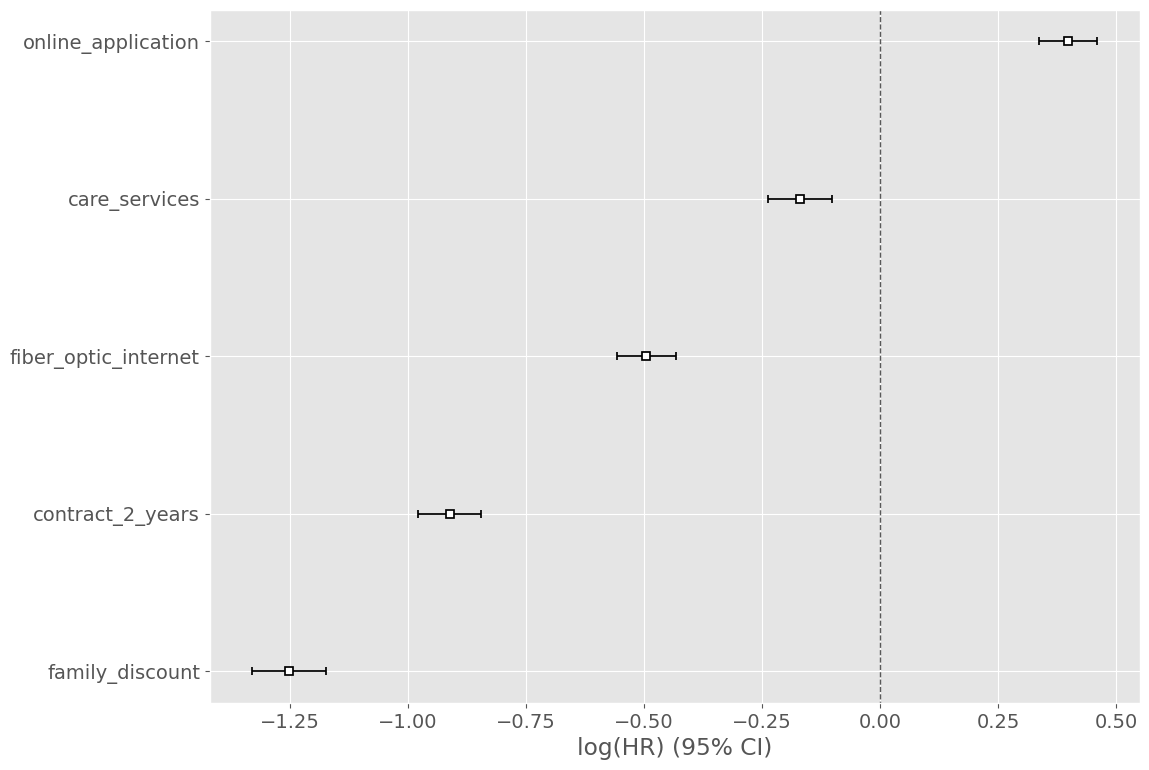

In [6]:
#
# 係数のプロット
#

cph.plot()
plt.show()

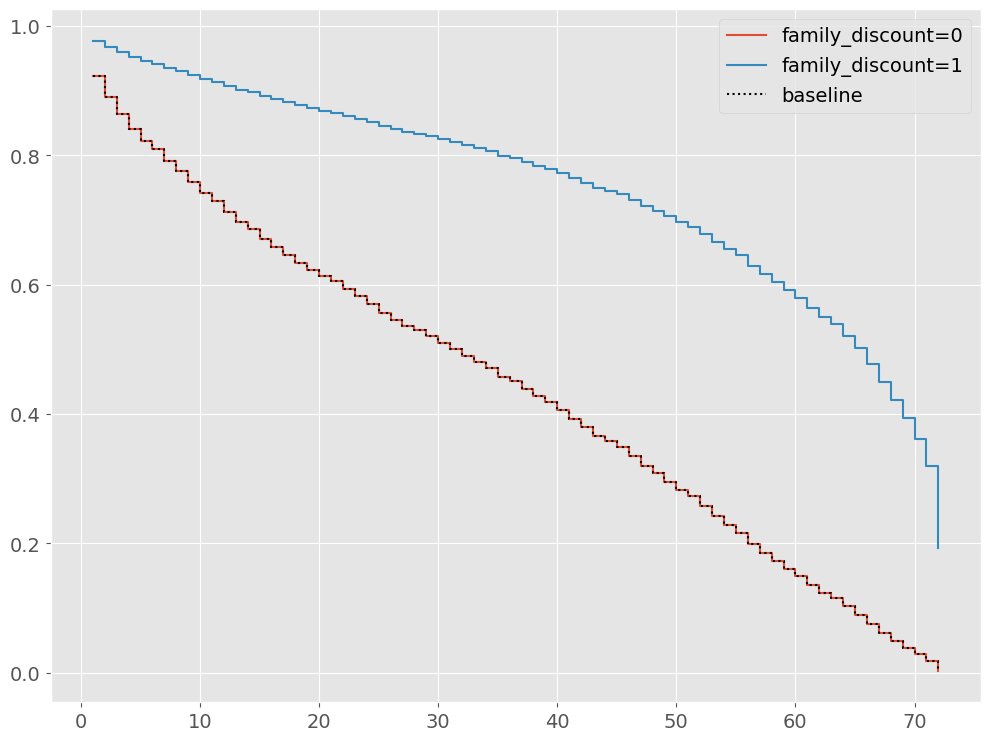

In [7]:
#
# family_discountによる生存関数の違い
#

cph.plot_partial_effects_on_outcome(
    'family_discount', values=[0, 1])
plt.show()

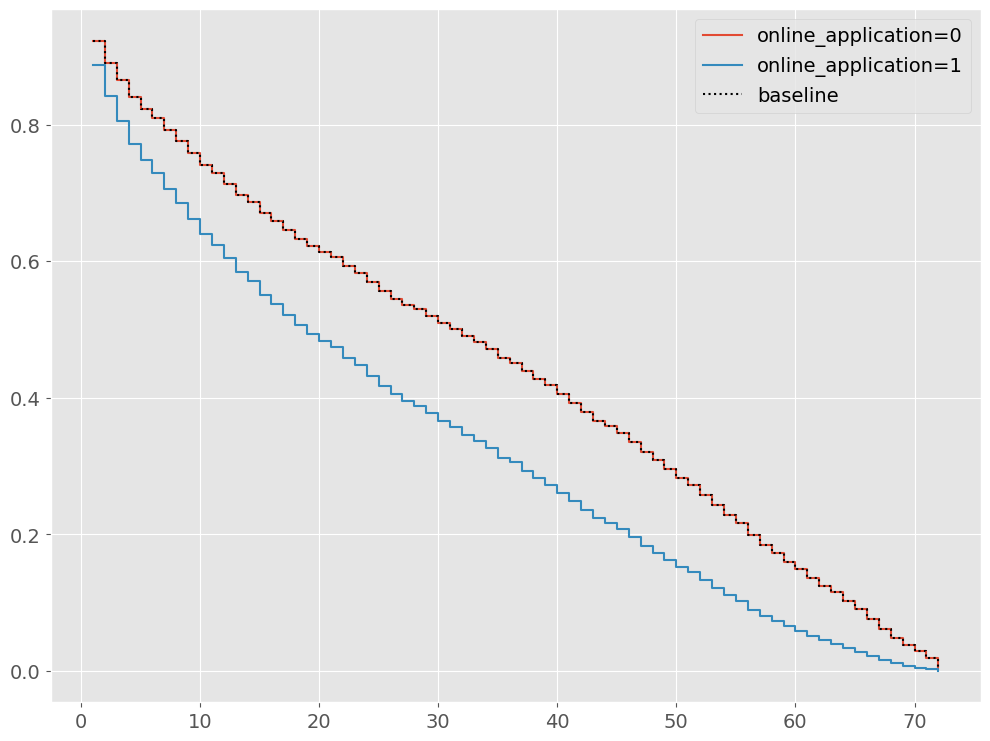

In [8]:
#
# fonline_applicationによる生存関数の違い
#

cph.plot_partial_effects_on_outcome(
    'online_application', values=[0, 1])
plt.show()

## ステップ3：継続ユーザ（離反していないユーザ）の離反時期予測

### 離反時期予測モデルの検討

In [9]:
#
# データセットの分割（学習データとテストデータ）
#

df_train, df_test = train_test_split(
    df,
    test_size=0.3,
    random_state=123)

In [10]:
#
# 離反時期予測モデルの学習（学習データ）
#

# 学習
cph.fit(
    df_train, 
    duration_col='tenure', 
    event_col='churn') 

<lifelines.CoxPHFitter: fitted with 6996 total observations, 4233 right-censored observations>

In [11]:
#
# 精度評価（C-index）
#

# 学習データ
c_index_train = concordance_index(
    df_train['tenure'],               
    -cph.predict_partial_hazard(df_train),     
    df_train['churn'])

# テストデータ
c_index_test = concordance_index(
    df_test['tenure'],
    -cph.predict_partial_hazard(df_test),
    df_test['churn'])

# 確認
print('c-index (train data):\n', c_index_train)
print('c-index (test data):\n', c_index_test)

c-index (train data):
 0.8002286818605346
c-index (test data):
 0.798566055848512


### 離反時期予測モデルの構築（全データで学習）

In [12]:
#
# 離反時期予測モデルの学習（全データ）
#

# 学習
cph.fit(
    df, 
    duration_col='tenure', 
    event_col='churn') 

# 精度評価（C-index）
concordance_index(
    df['tenure'],
    -cph.predict_partial_hazard(df),
    df['churn'])

0.7999245081313417

### 継続ユーザデータの抽出

In [13]:
#
# 継続ユーザデータの抽出
#

customers_data = df[df['churn'] == 0]

print(customers_data) #確認

            fiber_optic_internet  care_services  contract_2_years  \
id                                                                  
3030576346                     0              0                 0   
5846338138                     1              0                 1   
7946040136                     1              1                 1   
2129388731                     0              0                 0   
4675530834                     0              0                 1   
...                          ...            ...               ...   
7112472659                     0              0                 0   
5249470446                     1              0                 0   
3871698536                     0              0                 0   
6494681829                     0              0                 0   
4339680439                     0              0                 0   

            family_discount  online_application  tenure  churn  
id                                   

### 継続ユーザの生存関数（ユーザである確率）

In [14]:
#
# 継続ユーザの生存関数
#

pred_survival_after = cph.predict_survival_function(
    customers_data,
    conditional_after=customers_data['tenure'])

print(pred_survival_after) #確認

      3030576346  5846338138  7946040136  2129388731  4675530834  7910681853  \
1.0     0.966656    0.973486    0.996185    0.970993    0.972709    0.990114   
2.0     0.944612    0.949066    0.991820    0.937868    0.952701    0.980560   
3.0     0.911776    0.916124    0.985835    0.906633    0.920942    0.973663   
4.0     0.889041    0.887199    0.982917    0.884549    0.887286    0.964533   
5.0     0.862369    0.863074    0.977408    0.855912    0.856924    0.955215   
...          ...         ...         ...         ...         ...         ...   
68.0    0.000315    0.232592    0.352827    0.000269    0.066152    0.095892   
69.0    0.000315    0.232592    0.352827    0.000269    0.066152    0.095892   
70.0    0.000315    0.232592    0.352827    0.000269    0.066152    0.095892   
71.0    0.000315    0.232592    0.352827    0.000269    0.066152    0.095892   
72.0    0.000315    0.232592    0.352827    0.000269    0.066152    0.095892   

      8727576136  4848186549  857051906

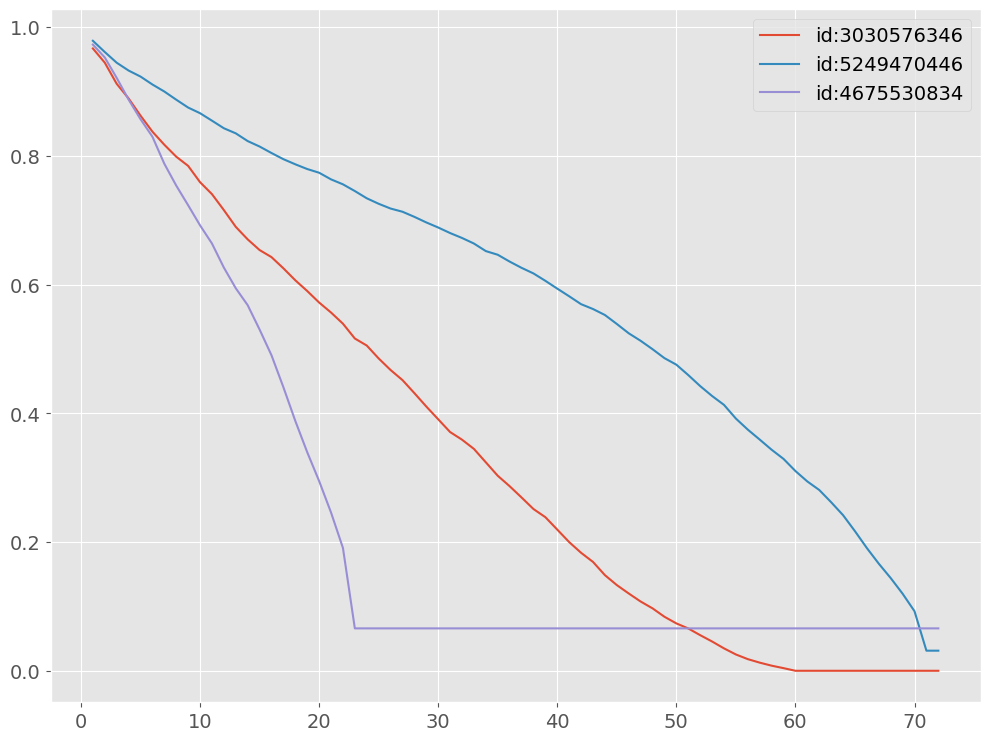

In [15]:
#
# 特定の継続ユーザの生存関数のグラフ化
#

customer1 = 3030576346
customer2 = 5249470446
customer3 = 4675530834

pred_survival_after[customer1].plot(label="id:"+str(customer1))
pred_survival_after[customer2].plot(label="id:"+str(customer2))
pred_survival_after[customer3].plot(label="id:"+str(customer3))

plt.legend()
plt.show()

### 継続ユーザの離反時期の予測（中央値）

In [16]:
#
# 離反時期予測（中央値）
#

churn_pred = cph.predict_median(
    customers_data,
    conditional_after=customers_data['tenure'])

print(churn_pred) #確認

3030576346    25.0
5846338138    13.0
7946040136    40.0
2129388731    25.0
4675530834    16.0
              ... 
7112472659    23.0
5249470446    48.0
3871698536    23.0
6494681829    34.0
4339680439    23.0
Name: 0.5, Length: 6104, dtype: float64


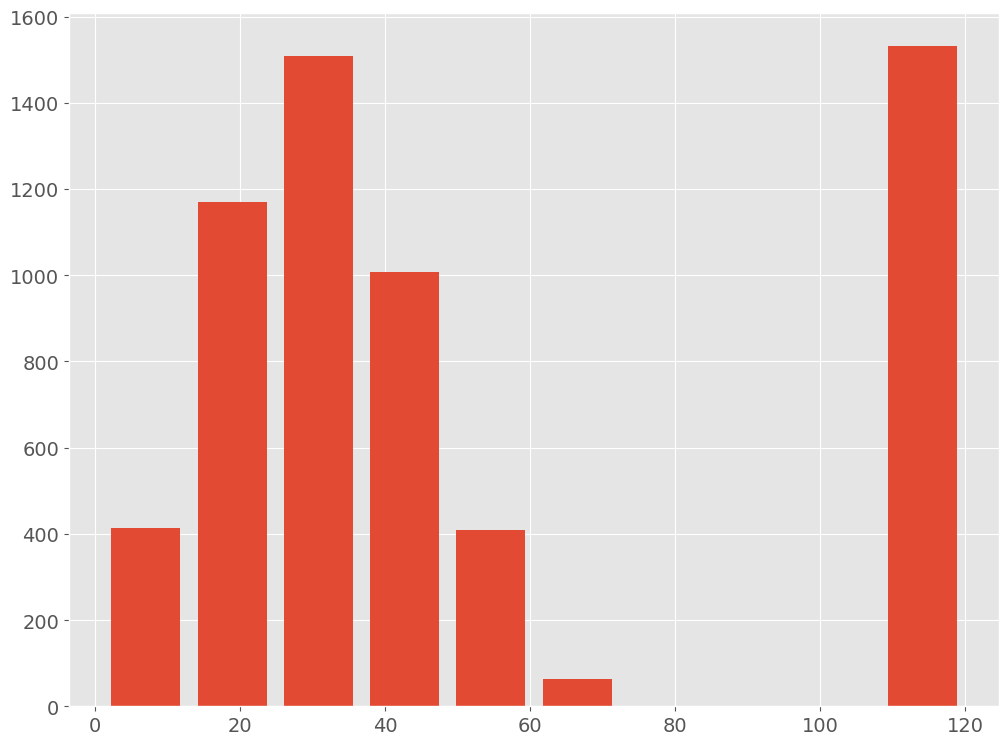

In [17]:
#
# ヒストグラム（度数分布）※infは120と設定
#

plt.hist(
    churn_pred.replace([np.inf], 120), 
    bins=10, 
    rwidth=0.8)
plt.show()

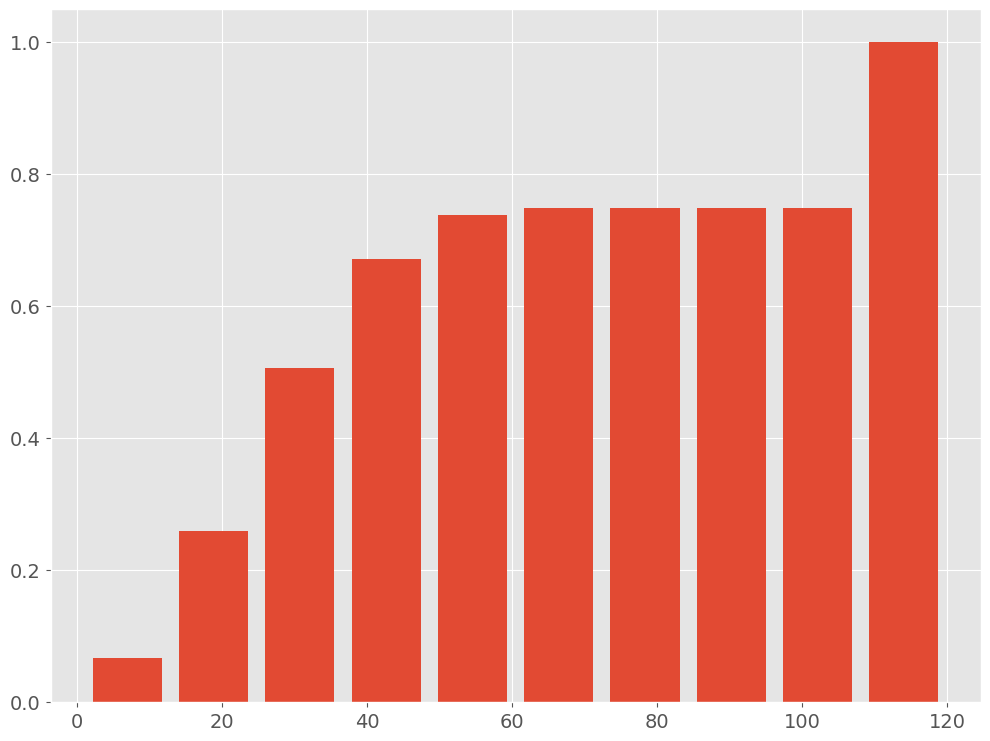

In [18]:
#
# 累積ヒストグラム（％）※infは120と設定
#

plt.hist(
    churn_pred.replace([np.inf], 120), 
    bins=10, 
    rwidth=0.8, 
    density=True, 
    cumulative=True)

plt.show()

In [19]:
#
# 離反時期の早い順に並び替える
#

print(churn_pred.sort_values())

8127259365    1.0
4540180655    1.0
5357142243    1.0
3352307141    1.0
7656218363    1.0
             ... 
8039654537    inf
5466673555    inf
2801231843    inf
8608504854    inf
4718346129    inf
Name: 0.5, Length: 6104, dtype: float64


In [20]:
#
# 3ヶ月以内に離反しそうなユーザ
#

print(churn_pred[churn_pred <= 3])

2544589625    2.0
1226468151    2.0
6886360135    2.0
1225468151    2.0
5357142243    1.0
7357160047    3.0
2690619547    3.0
1599015362    2.0
7033176522    1.0
6142344846    2.0
1335344553    2.0
8922485740    1.0
4760380825    3.0
7582589157    3.0
8453641151    3.0
8127259365    1.0
7369278430    1.0
3480690333    3.0
3282141431    3.0
8999204536    3.0
4540180655    1.0
1028638227    2.0
8060698237    1.0
2689619547    3.0
6762613036    3.0
8128220633    3.0
7909341456    3.0
6877071951    3.0
7656218363    1.0
5423624726    3.0
6754582640    3.0
4984377847    3.0
6876071951    3.0
5202268038    3.0
3352307141    1.0
2053461665    2.0
4011126153    3.0
1053001665    3.0
6730500755    1.0
7381194353    2.0
8653275332    3.0
4309239023    1.0
5365550946    1.0
Name: 0.5, dtype: float64


In [21]:
#
# 離反時期予測（第1四分位数，中央値（第2四分位数），第3四分位数）
#

churn_pred = cph.predict_percentile(
    customers_data,
    p=[0.25,0.5,0.75],
    conditional_after=customers_data['tenure'])

print(churn_pred) #確認

            0.25  0.50  0.75
3030576346  39.0  25.0  11.0
5846338138  14.0  13.0   8.0
7946040136   inf  40.0  31.0
2129388731  41.0  25.0  10.0
4675530834  21.0  16.0   9.0
...          ...   ...   ...
7112472659  43.0  23.0   9.0
5249470446  64.0  48.0  23.0
3871698536  43.0  23.0   9.0
6494681829  53.0  34.0  13.0
4339680439  43.0  23.0   8.0

[6104 rows x 3 columns]
